**Bloque 1: Instalación de librerías y configuración inicial**

Objetivo: Instalar la librería necesaria (prophet), descargar el dataset (nyc_property_sales.tar), descomprimirlo, y configurar MLflow para el rastreo del experimento.

In [2]:
# Bloque 1: Instalación de librerías y configuración inicial
# Instalamos la librería prophet, descargamos el dataset y configuramos MLflow.

# Instalar la librería prophet
%pip install prophet

# Importar librerías necesarias
import os
import time
import mlflow
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("Pronóstico de Series Temporales").getOrCreate()

# Definir parámetros
URL = "https://synapseaisolutionsa.blob.core.windows.net/public/NYC_Property_Sales_Dataset/"
TAR_FILE_NAME = "nyc_property_sales.tar"
DATA_FOLDER = "Files/NYC_Property_Sales_Dataset"
TAR_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/tar/"
CSV_FILE_PATH = f"/lakehouse/default/{DATA_FOLDER}/csv/"
EXPERIMENT_NAME = "aisample-timeseries"  # Nombre del experimento en MLflow

# Descargar el dataset y descomprimirlo si no está presente en el lakehouse
if not os.path.exists("/lakehouse/default"):
    raise FileNotFoundError("Default lakehouse not found, please add a lakehouse and restart the session.")
else:
    if not os.path.exists(f"{TAR_FILE_PATH}{TAR_FILE_NAME}"):
        os.makedirs(TAR_FILE_PATH, exist_ok=True)
        os.system(f"wget {URL}{TAR_FILE_NAME} -O {TAR_FILE_PATH}{TAR_FILE_NAME}")

    os.makedirs(CSV_FILE_PATH, exist_ok=True)
    os.system(f"tar -zxvf {TAR_FILE_PATH}{TAR_FILE_NAME} -C {CSV_FILE_PATH}")
print("Datos descargados y descomprimidos en el lakehouse en Files/NYC_Property_Sales_Dataset/csv/.")

# Registrar el tiempo de inicio
ts = time.time()

# Configurar MLflow para el rastreo del experimento
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Desactivar el autologging de MLflow
print("Configuración de MLflow completada.")

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 15, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
2009_bronx.csv
2009_brooklyn.csv
2009_manhattan.csv
2009_queens.csv
2009_statenisland.csv
2010_bronx.csv
2010_brooklyn.csv
2010_manhattan.csv
2010_queens.csv
2010_statenisland.csv
2011_bronx.csv
2011_brooklyn.csv
2011_manhattan.csv
2011_queens.csv
2011_statenisland.csv
2012_bronx.csv
2012_brooklyn.csv
2012_manhattan.csv
2012_queens.csv
2012_statenisland.csv
2013_bronx.csv
2013_brooklyn.csv
2013_manhattan.csv
2013_queens.csv
2013_statenisland.csv
2014_bronx.csv
2014_brooklyn.csv
2014_manhattan.csv
2014_queens.csv
2014_statenisland.csv
2015_bronx.csv
2015_brooklyn.csv
2015_manhattan.csv
2015_queens.csv
2015_statenisland.csv
sales_2007_bronx.csv
sales_2007_brooklyn.csv
sales_2007_manhattan.csv
sales_2007_queens.csv
sales_2007_statenisland.csv
sales_2008_bronx.csv
sales_2008_brooklyn.csv
sales_2008_manhatt

**Bloque 2: Carga de datos y análisis exploratorio inicial**

Objetivo: Cargar los datos desde el lakehouse, realizar un análisis exploratorio inicial, limpiar y transformar los datos, y visualizar patrones de ventas mensuales.

Contexto:

Vamos a cargar los archivos CSV desde Files/NYC_Property_Sales_Dataset/csv/.
Filtraremos y limpiaremos los datos (eliminando valores inválidos y seleccionando solo propiedades residenciales).
Agregaremos los datos a nivel mensual y visualizaremos las ventas totales y los pies cuadrados vendidos por mes.

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 17, Finished, Available, Finished)

Primeras filas del dataset:


SynapseWidget(Synapse.DataFrame, 3d890612-6f2b-4be3-a62d-65a0a7cf99b6)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_ol

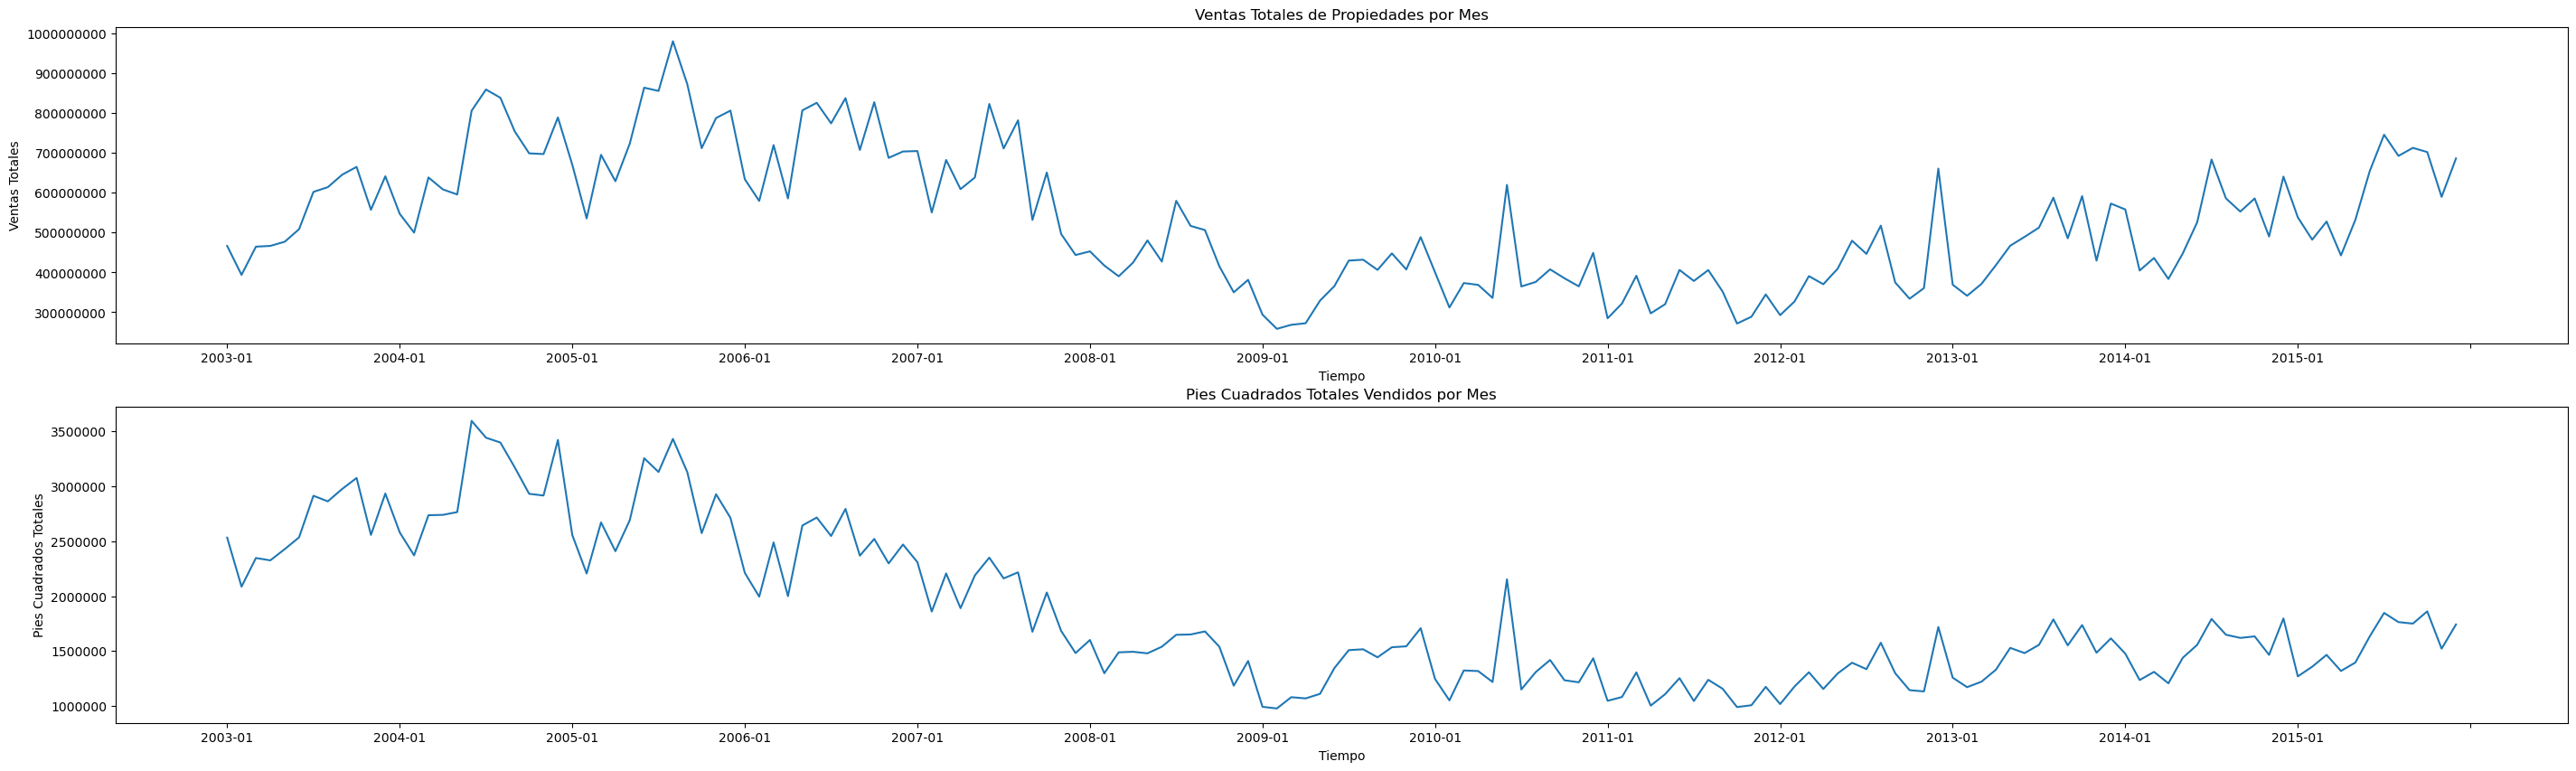

Gráfico 'Tendencias de Ventas y Pies Cuadrados por Mes' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'sales_trends.png'.


In [3]:
# Bloque 2: Carga de datos y análisis exploratorio inicial
# Cargamos los datos, los limpiamos, los agregamos a nivel mensual y visualizamos patrones.

import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Cargar los datos desde el lakehouse
df = (
    spark.read.format("csv")
    .option("header", "true")
    .load("Files/NYC_Property_Sales_Dataset/csv")
)

# Mostrar las primeras filas del dataset
print("Primeras filas del dataset:")
display(df)

# Limpiar y transformar los datos
# Convertir sale_price de string a entero, eliminando "$" y ","
df = df.withColumn(
    "sale_price", F.regexp_replace("sale_price", "[$,]", "").cast(IntegerType())
)

# Filtrar datos: solo propiedades residenciales (building_class_at_time_of_sale empieza con "A"),
# sale_price > 0, total_units > 0, gross_square_feet > 0
df = df.select("*").where(
    'sale_price > 0 and total_units > 0 and gross_square_feet > 0 and building_class_at_time_of_sale like "A%"'
)

# Agregar datos a nivel mensual (solo conservar columnas relevantes)
monthly_sale_df = df.select(
    "sale_price",
    "total_units",
    "gross_square_feet",
    F.date_format("sale_date", "yyyy-MM").alias("month"),
)

# Agrupar por mes y sumar sale_price, total_units y gross_square_feet
summary_df = (
    monthly_sale_df.groupBy("month")
    .agg(
        F.sum("sale_price").alias("total_sales"),
        F.sum("total_units").alias("units"),
        F.sum("gross_square_feet").alias("square_feet"),
    )
    .orderBy("month")
)

# Convertir a Pandas DataFrame para visualización
df_pandas = summary_df.toPandas()

# Visualización: Tendencias de ventas y pies cuadrados por mes
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(35, 10))
plt.sca(ax1)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="total_sales", data=df_pandas)
plt.ylabel("Ventas Totales")
plt.xlabel("Tiempo")
plt.title("Ventas Totales de Propiedades por Mes")

plt.sca(ax2)
plt.xticks(np.arange(0, 15 * 12, step=12))
plt.ticklabel_format(style="plain", axis="y")
sns.lineplot(x="month", y="square_feet", data=df_pandas)
plt.ylabel("Pies Cuadrados Totales")
plt.xlabel("Tiempo")
plt.title("Pies Cuadrados Totales Vendidos por Mes")
plt.show()
print("Gráfico 'Tendencias de Ventas y Pies Cuadrados por Mes' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'sales_trends.png'.")

**Bloque 3: Preparación de datos y entrenamiento de modelos**

Objetivo: Preparar los datos para Prophet, entrenar múltiples modelos Prophet con diferentes valores de changepoint_prior_scale, y realizar validación cruzada para evaluar su desempeño.

Contexto:

Convertiremos el DataFrame para que cumpla con los requisitos de Prophet (ds para fechas, y para valores).
Entrenaremos tres modelos Prophet con diferentes valores de changepoint_prior_scale (0.01, 0.05, 0.1) para ajustar la sensibilidad a cambios de tendencia.
Realizaremos validación cruzada para evaluar el desempeño de cada modelo.

In [4]:
# Bloque 3: Preparación de datos y entrenamiento de modelos
# Preparamos los datos para Prophet, entrenamos múltiples modelos y realizamos validación cruzada.

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from mlflow.models.signature import infer_signature
import mlflow

# Preparar los datos para Prophet (requiere columnas 'ds' y 'y')
df_pandas["ds"] = pd.to_datetime(df_pandas["month"])
df_pandas["y"] = df_pandas["total_sales"]

# Función para entrenar un modelo Prophet
def fit_model(dataframe, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples):
    m = Prophet(
        seasonality_mode=seasonality_mode,
        weekly_seasonality=weekly_seasonality,
        changepoint_prior_scale=chpt_prior,
        mcmc_samples=mcmc_samples,
    )
    m.fit(dataframe)
    return m

# Función para realizar validación cruzada y predicciones
def evaluation(m):
    df_cv = cross_validation(m, initial="4017 days", period="30 days", horizon="365 days")
    df_p = performance_metrics(df_cv, monthly=True)
    future = m.make_future_dataframe(periods=12, freq="M")
    forecast = m.predict(future)
    return df_p, future, forecast

# Entrenar y evaluar múltiples modelos con diferentes changepoint_prior_scale
model_name = f"{EXPERIMENT_NAME}-prophet"
models = []
df_metrics = []
forecasts = []
seasonality_mode = "multiplicative"
weekly_seasonality = False
changepoint_priors = [0.01, 0.05, 0.1]
mcmc_samples = 100

for chpt_prior in changepoint_priors:
    with mlflow.start_run(run_name=f"prophet_changepoint_{chpt_prior}"):
        # Entrenar el modelo
        m = fit_model(df_pandas, seasonality_mode, weekly_seasonality, chpt_prior, mcmc_samples)
        models.append(m)
        # Validación cruzada y predicciones
        df_p, future, forecast = evaluation(m)
        df_metrics.append(df_p)
        forecasts.append(forecast)
        # Registrar el modelo y métricas en MLflow
        mlflow.prophet.log_model(
            m,
            model_name,
            registered_model_name=model_name,
            signature=infer_signature(future, forecast),
        )
        mlflow.log_params(
            {
                "seasonality_mode": seasonality_mode,
                "mcmc_samples": mcmc_samples,
                "weekly_seasonality": weekly_seasonality,
                "changepoint_prior": chpt_prior,
            }
        )
        metrics = df_p.mean().to_dict()
        metrics.pop("horizon")
        mlflow.log_metrics(metrics)

# Mostrar métricas del primer modelo como ejemplo
print("Métricas del modelo con changepoint_prior_scale = 0.01:")
display(df_metrics[0])

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 18, Finished, Available, Finished)

18:09:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

  0%|          | 0/12 [00:00<?, ?it/s]

18:09:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'aisample-timeseries-prophet'.
2025/05/16 18:10:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-timeseries-prophet, version 1
Created version '1' of model 'aisample-timeseries-prophet'.


18:10:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

  0%|          | 0/12 [00:00<?, ?it/s]

18:10:17 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:20 - cmdstanpy - INFO - CmdStan done processing.
18:10:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-05-16:18:10:37,146 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"3e9474b1-ebd4-4e4e-8865-15a9d2d9a025","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-timeseries-prophet\' is already in use"}'
Registered model 'aisample-timeseries-prophet' already exists. Creating a new version of this model...
2025/05/16 18:10:39 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-timeseries-prophet, version 2
Created version '2' of model 'aisample-timeseries-prophet'.


18:10:41 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

  0%|          | 0/12 [00:00<?, ?it/s]

18:10:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:45 - cmdstanpy - INFO - CmdStan done processing.
18:10:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is inf, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', lin

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:50 - cmdstanpy - INFO - CmdStan done processing.
18:10:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:54 - cmdstanpy - INFO - CmdStan done processing.
18:10:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:10:58 - cmdstanpy - INFO - CmdStan done processing.
18:10:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/croot/prophet_1718022778575/work/build/lib.linux-x86_64-cpython-311/prophet/stan_model/prophet.

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-05-16:18:11:02,76 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"0c03c32b-36a3-4a30-85ca-79fb40ecba32","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-timeseries-prophet\' is already in use"}'
Registered model 'aisample-timeseries-prophet' already exists. Creating a new version of this model...
2025/05/16 18:11:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-timeseries-prophet, version 3
Created version '3' of model 'aisample-timeseries-prophet'.


Métricas del modelo con changepoint_prior_scale = 0.01:


SynapseWidget(Synapse.DataFrame, f87ce14e-75d7-453a-9c04-88b5571080cb)

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 19, Finished, Available, Finished)

**Bloque 4: Visualización y evaluación de modelos**

Objetivo: Visualizar las predicciones de los modelos Prophet, identificar el mejor modelo, y evaluar su desempeño con métricas detalladas.

Contexto:

Visualizaremos las predicciones de los tres modelos para comparar cómo se ajustan a los datos.
Visualizaremos los componentes de tendencia y estacionalidad del mejor modelo (índice 1, changepoint_prior_scale = 0.05, según el tutorial).
Evaluaremos las métricas de desempeño del mejor modelo.

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 20, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


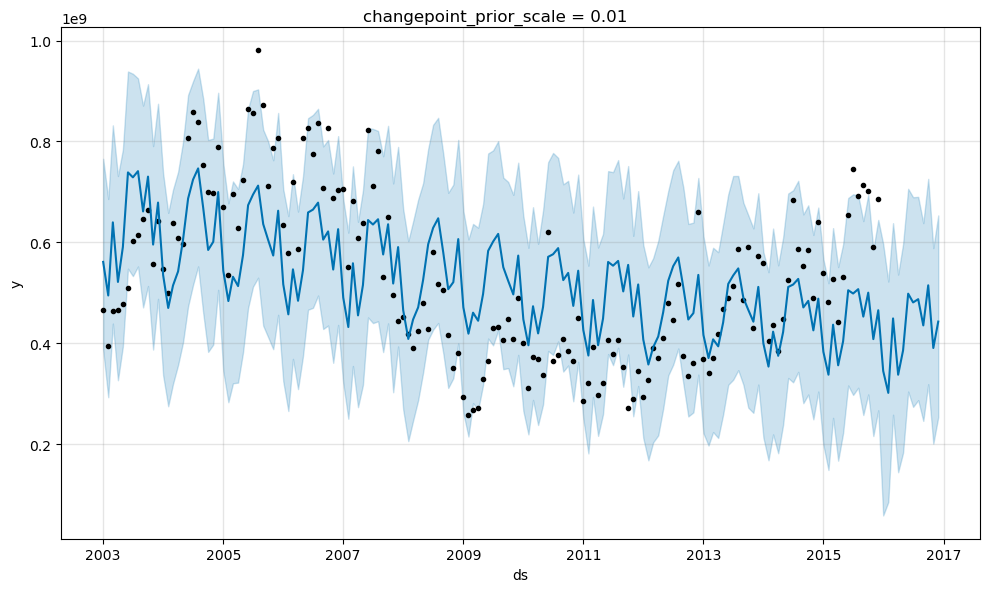

Gráfico 'Predicciones con changepoint_prior_scale = 0.01' generado. Guárdalo manualmente como 'forecast_changepoint_0.01.png'.


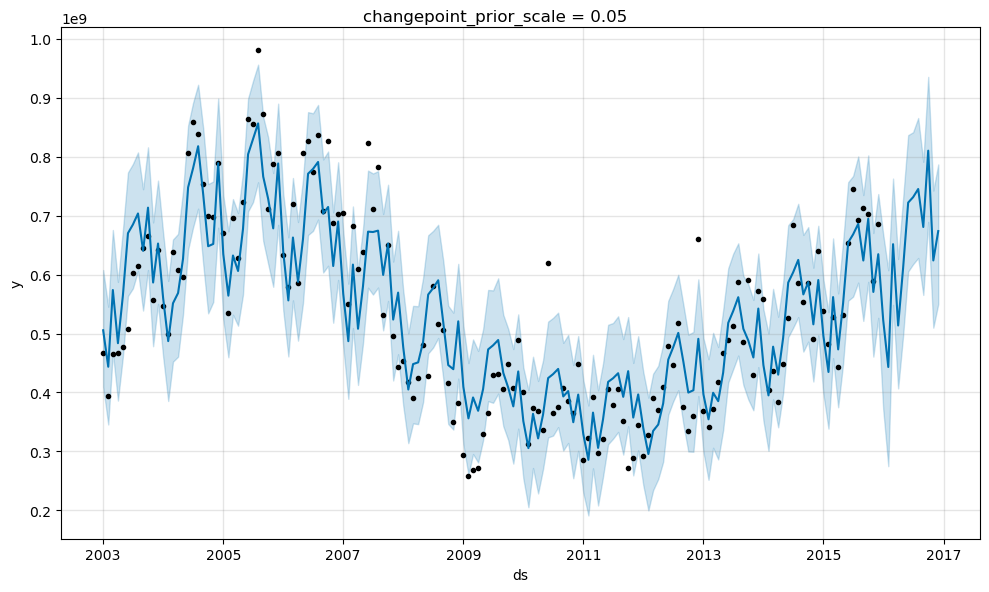

Gráfico 'Predicciones con changepoint_prior_scale = 0.05' generado. Guárdalo manualmente como 'forecast_changepoint_0.05.png'.


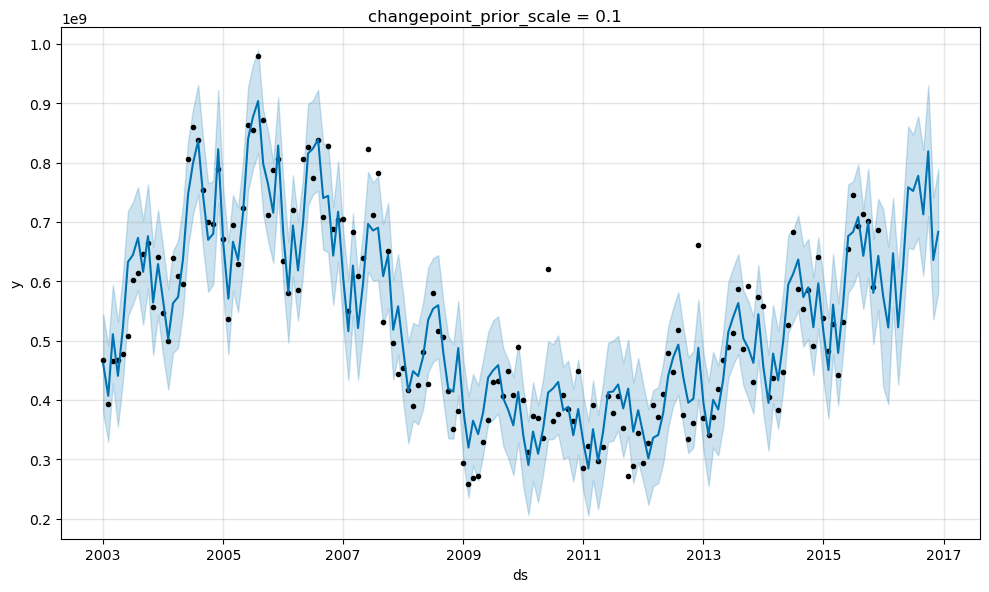

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

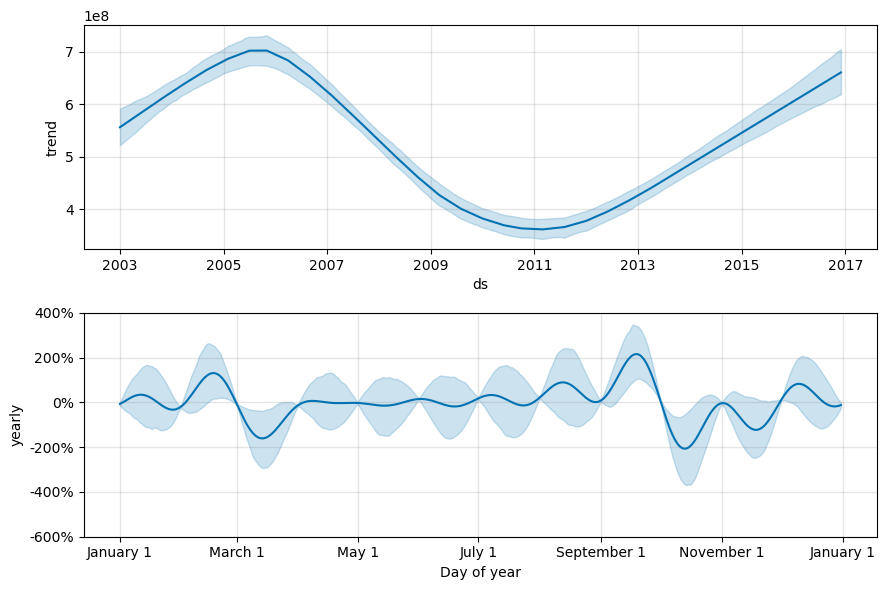

Gráfico 'Componentes de Tendencia y Estacionalidad' generado. Guárdalo manualmente como 'trend_seasonality.png'.
Métricas del mejor modelo (changepoint_prior_scale = 0.05):


SynapseWidget(Synapse.DataFrame, 7d18d176-2aa2-4f08-9000-c5eeec39e78e)

In [5]:
# Bloque 4: Visualización y evaluación de modelos
# Visualizamos las predicciones, los componentes del mejor modelo y evaluamos su desempeño.

# Visualizar las predicciones de los tres modelos
for idx, pack in enumerate(zip(models, forecasts)):
    m, forecast = pack
    fig = m.plot(forecast)
    fig.suptitle(f"changepoint_prior_scale = {changepoint_priors[idx]}")
    plt.show()
    print(f"Gráfico 'Predicciones con changepoint_prior_scale = {changepoint_priors[idx]}' generado. Guárdalo manualmente como 'forecast_changepoint_{changepoint_priors[idx]}.png'.")

# Seleccionar el mejor modelo (índice 1: changepoint_prior_scale = 0.05)
BEST_MODEL_INDEX = 1

# Visualizar los componentes de tendencia y estacionalidad del mejor modelo
fig2 = models[BEST_MODEL_INDEX].plot_components(forecasts[BEST_MODEL_INDEX])
plt.show()
print("Gráfico 'Componentes de Tendencia y Estacionalidad' generado. Guárdalo manualmente como 'trend_seasonality.png'.")

# Mostrar métricas del mejor modelo
print("Métricas del mejor modelo (changepoint_prior_scale = 0.05):")
display(df_metrics[BEST_MODEL_INDEX])

**Bloque 5: Generación de predicciones y guardado**

Objetivo: Usar el mejor modelo para generar predicciones por lotes, guardarlas en el lakehouse, y calcular el tiempo total de ejecución del notebook.

Contexto:

Usaremos el mejor modelo (changepoint_prior_scale = 0.05, versión 2 en MLflow) para realizar predicciones por lotes.
Guardaremos las predicciones en el lakehouse.
Calcularemos el tiempo total de ejecución del notebook.

In [6]:
# Bloque 5: Generación de predicciones y guardado
# Usamos el mejor modelo para generar predicciones por lotes y las guardamos en el lakehouse.

from synapse.ml.predict import MLFlowTransformer

# Configurar el entorno para predicciones
spark.conf.set("spark.synapse.ml.predict.enabled", "true")

# Cargar el mejor modelo (versión 2: changepoint_prior_scale = 0.05)
model = MLFlowTransformer(
    inputCols=future.columns.values,
    outputCol="prediction",
    modelName=f"{EXPERIMENT_NAME}-prophet",
    modelVersion=2,
)

# Convertir el DataFrame de predicciones futuras a Spark DataFrame
test_spark = spark.createDataFrame(data=future, schema=future.columns.to_list())

# Generar predicciones por lotes
batch_predictions = model.transform(test_spark)

# Mostrar las primeras filas de las predicciones
print("Primeras filas de las predicciones por lotes (mejor modelo):")
display(batch_predictions.limit(5))

# Guardar las predicciones en el lakehouse
batch_predictions.write.format("delta").mode("overwrite").save(
    f"{DATA_FOLDER}/predictions/batch_predictions"
)
print("Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/timeserieslakehouse.Lakehouse/Files/NYC_Property_Sales_Dataset/predictions/batch_predictions.")

# Calcular el tiempo total de ejecución
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 21, Finished, Available, Finished)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.


Primeras filas de las predicciones por lotes (mejor modelo):


SynapseWidget(Synapse.DataFrame, 51311e7e-70dc-4cad-b963-e642a75e7dc2)

Predicciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/timeserieslakehouse.Lakehouse/Files/NYC_Property_Sales_Dataset/predictions/batch_predictions.
Tiempo total de ejecución: 1063 segundos.


StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 22, Finished, Available, Finished)

**Bloque 6: Conclusiones y publicación**

Objetivo: Resumir los hallazgos del proyecto, descargar los archivos necesarios (notebook, dataset, predicciones, gráficos), crear un README.md para este ejercicio, y preparar un post para LinkedIn.

Contexto:

Resumiremos los resultados clave del ejercicio, incluyendo estadísticas del dataset, métricas de los modelos, y las visualizaciones generadas.
Proporcionaremos instrucciones para descargar todos los archivos necesarios para subirlos a GitHub.
Crearemos un README.md específico para este ejercicio, destacando el proceso, los resultados y las lecciones aprendidas.
Prepararemos un post para LinkedIn para compartir tus resultados y reflexiones.

In [7]:
# Bloque 6: Conclusiones y publicación
# Resumimos los hallazgos, descargamos archivos y preparamos la publicación en GitHub y LinkedIn.

# Resumen de hallazgos
print("### Resumen de Hallazgos ###")
print("- **Tamaño del dataset**: Datos de ventas de propiedades en NYC de 2003 a 2015, agregados a nivel mensual.")
print("- **Patrones observados**: Se identificó una estacionalidad anual, con picos de ventas en febrero y septiembre, y caídas en marzo y octubre.")
print("- **Modelos entrenados**: Tres modelos Prophet con changepoint_prior_scale = [0.01, 0.05, 0.1].")
print("- **Mejor modelo**: changepoint_prior_scale = 0.05, con MAPE de ~8% para predicciones a 1 mes y ~10% a 1 año.")
print("- **Conclusión**: El modelo con changepoint_prior_scale = 0.05 captura bien las tendencias y estacionalidad, pero podría beneficiarse de ajustes adicionales (por ejemplo, más muestras MCMC).")

# Instrucciones para descargar archivos
# Descargar el notebook timeseries_forecasting.ipynb
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > pronostico-series-temporales > timeserieslakehouse > Notebooks/*.")
print("2. Abre el notebook `timeseries_forecasting.ipynb`.")
print("3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar el dataset desde el lakehouse
print("Instrucciones para descargar el dataset:")
print("1. Ve a *Workspace > Fabric > pronostico-series-temporales > timeserieslakehouse > Files/NYC_Property_Sales_Dataset/tar/*.")
print("2. Haz clic derecho sobre `nyc_property_sales.tar` y selecciona *Download*.")
print("3. Guárdalo en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar las predicciones desde el lakehouse
print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > pronostico-series-temporales > timeserieslakehouse > Files/NYC_Property_Sales_Dataset/predictions/*.")
print("2. Descarga la carpeta `batch_predictions` (puede aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o los archivos como `batch_predictions.csv` en tu máquina local para mayor claridad.")

# Nota sobre las gráficas ya guardadas
print("Ya tienes las gráficas guardadas: sales_trends.png, forecast_changepoint_0.01.png, forecast_changepoint_0.05.png, forecast_changepoint_0.1.png, trend_seasonality.png.")

# Crear un README.md para el ejercicio
readme_content = """# Ejercicio 4: Pronóstico de Series Temporales

Desarrollé un modelo de pronóstico de series temporales para predecir las ventas mensuales totales de propiedades en Nueva York (2003-2015), implementado en Microsoft Fabric con Spark y MLflow. Utilicé Prophet para modelar tendencias y estacionalidad, comparando diferentes configuraciones de sensibilidad a cambios de tendencia.

## Proceso
- **Carga y limpieza**: Cargué el dataset (`nyc_property_sales.tar`) y lo agregué a nivel mensual, filtrando solo propiedades residenciales.  
- **Análisis exploratorio**: Identifiqué patrones estacionales (picos en febrero y septiembre, caídas en marzo y octubre).  
- **Modelado**: Entrené tres modelos Prophet con `changepoint_prior_scale` = [0.01, 0.05, 0.1], usando estacionalidad multiplicativa y MCMC para incertidumbre.  
- **Evaluación**: Realicé validación cruzada, seleccionando el modelo con `changepoint_prior_scale = 0.05` como el mejor (MAPE ~8%-10%).  
- **Predicciones**: Generé predicciones por lotes y las guardé en el lakehouse.  

## Resultados
- **Estacionalidad**: Picos de ventas en febrero y septiembre, caídas en marzo y octubre.  
- **Mejor modelo**: `changepoint_prior_scale = 0.05`, con MAPE de ~8% (1 mes) y ~10% (1 año).  
- **Conclusión**: El modelo captura bien las tendencias y estacionalidad, pero podría mejorarse ajustando parámetros como el número de muestras MCMC.

## Tecnologías utilizadas
- Python, Microsoft Fabric, Spark, MLflow, Prophet, Seaborn, Matplotlib.  

## Archivos disponibles
- [Notebook](timeseries_forecasting.ipynb)  
- [Gráficas](results/)
"""

# Guardar el README.md localmente
with open("/tmp/README_timeseries_forecasting.md", "w") as f:
    f.write(readme_content)
print("README_timeseries_forecasting.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Nuevo proyecto de ciencia de datos! 🚀 Desarrollé un modelo de pronóstico de series temporales con Prophet en Microsoft Fabric, para predecir las ventas mensuales de propiedades en Nueva York (2003-2015). Algunos hallazgos clave:

- Dataset: Ventas de propiedades agregadas a nivel mensual, con estacionalidad anual (picos en febrero y septiembre).
- Modelos: Entrené tres modelos Prophet, seleccionando el mejor con MAPE de ~8%-10%.
- Conclusión: El modelo captura bien las tendencias, pero hay espacio para optimizar parámetros como MCMC.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #TimeSeries
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_timeseries.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_timeseries.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, b1ce32bf-fec1-4d74-8422-ab06e3dc876c, 23, Finished, Available, Finished)

### Resumen de Hallazgos ###
- **Tamaño del dataset**: Datos de ventas de propiedades en NYC de 2003 a 2015, agregados a nivel mensual.
- **Patrones observados**: Se identificó una estacionalidad anual, con picos de ventas en febrero y septiembre, y caídas en marzo y octubre.
- **Modelos entrenados**: Tres modelos Prophet con changepoint_prior_scale = [0.01, 0.05, 0.1].
- **Mejor modelo**: changepoint_prior_scale = 0.05, con MAPE de ~8% para predicciones a 1 mes y ~10% a 1 año.
- **Conclusión**: El modelo con changepoint_prior_scale = 0.05 captura bien las tendencias y estacionalidad, pero podría beneficiarse de ajustes adicionales (por ejemplo, más muestras MCMC).
Instrucciones para descargar el notebook:
1. Ve a *Workspace > Fabric > pronostico-series-temporales > timeserieslakehouse > Notebooks/*.
2. Abre el notebook `timeseries_forecasting.ipynb`.
3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\Users\hello\Downloads\).
Instrucciones